In [24]:
import sys
import pennylane as qml
from pennylane import numpy as np
from math import pi
from sklearn import datasets
import scipy
import numpy as np
import time
import math

In [25]:
numQubits = 4
depth = 9
d = 40

In [26]:
dev = qml.device("default.qubit", wires=numQubits)

In [27]:
iris = datasets.load_iris()
X = iris.data[:, :][0:100]
y = iris.target[0:100]

In [28]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [47]:
def add_layerRZ(data):
    for i in range(numQubits):
        qml.RZ(data[i], wires = i)

def make_feature_map(data):
    for i in range(numQubits):
        qml.Hadamard(wires = i)
    add_layerRZ(data)

In [48]:
def add_cnots():
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qml.CNOT(wires = [i, j])

def add_layerRY(params):
    for qubit in range(numQubits):
        qml.RY(params[qubit], wires = qubit)
        
def make_variationalCircuit(params):
    add_cnots()
    add_layerRY(params)

In [49]:
def make_final_circuit(data, params, depth):
    make_feature_map(data)
    add_layerRY(params[0:numQubits])
    for i in range(depth):
        make_variationalCircuit(params[numQubits*(i+1):numQubits*(i+2)])

In [50]:
@qml.qnode(dev)
def qnode(params):
    make_final_circuit(data, params, depth)
    return qml.expval(qml.PauliX(1))

In [58]:
@qml.qnode(dev)
def fubini_qnode(data, params,depth):
    make_final_circuit(data, params,depth)
    return qml.state()

In [59]:
def fubini_calculate(data, params,depth):
    fubini = np.zeros([d, d], dtype=np.float64)
    base = np.conj(fubini_qnode(data,params,depth))
    for i in range(d):
        for j in range(d):
            params[i] += np.pi/2
            params[j] += np.pi/2
            plusplus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[j] -= np.pi
            plusminus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[i] -= np.pi
            minusminus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[j] += np.pi
            minusplus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            fubini[i, j] = (-plusplus-minusminus+plusminus+minusplus)/8
            params[i] += np.pi/2
            params[j] -= np.pi/2
    return fubini

In [60]:
def V_theta():
    return (2*pi)**(d)

In [61]:
def normalised_matrix(fisher_matrix):
    denominator = ((2*pi)**d)*np.trace(fisher_matrix)          
    return d*(V_theta()/denominator)*fisher_matrix

In [62]:
def effective_dimension(n, gamma, fisher_matrix):
    factor = (gamma*n)/(2*pi*math.log10(n))
    determinant = np.linalg.det(factor*normalised_matrix(fisher_matrix) + np.identity(fisher_matrix.shape[0]))
    integrate_det = ((2*pi)**d)*determinant**0.5
    return 2*math.log10(integrate_det/V_theta())/math.log10(factor)

In [65]:
fubini_matrices = []
effective_dim_eigen = []
effective_dim_formula = []
eigen_vals = []
gamma = 0.5
n = 10**6
cutoff_eigvals = 10**(-12)

In [116]:
start_qfi = time.time()

for i in range(70,100) :
    data = normalize(X[i])
    np.random.seed(0)
    params = np.random.uniform(-1, 1, d)
    print(params)
    fubini = fubini_calculate(data, params, depth)
    print(fubini)
    fubini_matrices.append(fubini)
    eigvals,eigvecs=scipy.linalg.eigh(fubini)
    eigen_vals.append(eigvals)
    nonzero_eigvals=eigvals[eigvals>cutoff_eigvals]
    eff_dim=len(nonzero_eigvals)
    eff_dim_form = effective_dimension(n, gamma, fubini)
    effective_dim_eigen.append(eff_dim)
    effective_dim_formula.append(eff_dim_form)
    
end_qfi = time.time()
print(end_qfi - start_qfi)

[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546    0.92732552 -0.23311696  0.58345008  0.05778984
  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321  0.66523969
  0.5563135   0.7400243   0.95723668  0.59831713 -0.07704128  0.56105835
 -0.76345115  0.27984204 -0.71329343  0.88933783  0.04369664 -0.17067612
 -0.47088878  0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099
  0.22419145  0.23386799  0.88749616  0.3636406 ]
[[ 1.46595740e-01 -1.38777878e-17  2.08166817e-17 ... -1.68275797e-02
  -1.56769635e-02  3.03872010e-02]
 [-3.46944695e-17  2.15795345e-01  6.93889390e-18 ...  9.54911107e-03
  -2.44861236e-02 -2.41972427e-02]
 [ 8.32667268e-17  6.93889390e-18  1.77577027e-01 ... -4.92668551e-02
  -6.04473553e-02 -4.72071803e-02]
 ...
 [-1.68275797e-02  9.54911107e-03 -4.92668551e-02 ...  2.06223787e-01
  -3.77644872e-02  1.83319093e-02]
 [-1.56769635e-02 -2.44861236e-02 -6.04473553e-02 ... -3.77644872e-02
   2.42316172e-01

[[ 1.36113407e-01 -1.04083409e-16 -7.63278329e-17 ... -1.52688380e-02
  -1.44771524e-02  2.79664078e-02]
 [ 6.93889390e-18  2.23481742e-01  1.38777878e-17 ...  6.26616041e-03
  -2.67037863e-02 -2.48252776e-02]
 [-2.08166817e-17  1.38777878e-17  1.81052479e-01 ... -5.05983715e-02
  -6.18533028e-02 -5.04099611e-02]
 ...
 [-1.52688380e-02  6.26616041e-03 -5.05983715e-02 ...  2.05700647e-01
  -3.85848387e-02  2.07071706e-02]
 [-1.44771524e-02 -2.67037863e-02 -6.18533028e-02 ... -3.85848387e-02
   2.42224620e-01  1.44762293e-01]
 [ 2.79664078e-02 -2.48252776e-02 -5.04099611e-02 ...  2.07071706e-02
   1.44762293e-01  2.45865881e-01]]
[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546    0.92732552 -0.23311696  0.58345008  0.05778984
  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321  0.66523969
  0.5563135   0.7400243   0.95723668  0.59831713 -0.07704128  0.56105835
 -0.76345115  0.27984204 -0.71329343  0.88933783  0.04369664 -0.17067612

[[ 1.42479727e-01  1.38777878e-17 -2.08166817e-17 ... -1.69521006e-02
  -1.60909392e-02  2.97984280e-02]
 [ 2.08166817e-17  2.11131523e-01 -9.02056208e-17 ...  9.39997673e-03
  -2.57856866e-02 -2.53256513e-02]
 [-2.08166817e-17 -9.02056208e-17  1.84700143e-01 ... -5.14811991e-02
  -6.17086983e-02 -4.94891780e-02]
 ...
 [-1.69521006e-02  9.39997673e-03 -5.14811991e-02 ...  2.07519023e-01
  -3.84093545e-02  1.98895312e-02]
 [-1.60909392e-02 -2.57856866e-02 -6.17086983e-02 ... -3.84093545e-02
   2.42168714e-01  1.40717604e-01]
 [ 2.97984280e-02 -2.53256513e-02 -4.94891780e-02 ...  1.98895312e-02
   1.40717604e-01  2.45362415e-01]]
[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546    0.92732552 -0.23311696  0.58345008  0.05778984
  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321  0.66523969
  0.5563135   0.7400243   0.95723668  0.59831713 -0.07704128  0.56105835
 -0.76345115  0.27984204 -0.71329343  0.88933783  0.04369664 -0.17067612

[[ 1.28881718e-01  4.85722573e-17  6.24500451e-17 ... -1.52435543e-02
  -1.46393678e-02  2.68307874e-02]
 [ 3.46944695e-17  2.19935296e-01 -1.38777878e-17 ...  5.41630838e-03
  -2.90131621e-02 -2.64575821e-02]
 [ 4.85722573e-17 -1.38777878e-17  1.90822173e-01 ... -5.38215545e-02
  -6.37608773e-02 -5.41648993e-02]
 ...
 [-1.52435543e-02  5.41630838e-03 -5.38215545e-02 ...  2.07344465e-01
  -3.95159082e-02  2.29842521e-02]
 [-1.46393678e-02 -2.90131621e-02 -6.37608773e-02 ... -3.95159082e-02
   2.42077603e-01  1.44433380e-01]
 [ 2.68307874e-02 -2.64575821e-02 -5.41648993e-02 ...  2.29842521e-02
   1.44433380e-01  2.46335990e-01]]
[ 0.09762701  0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823
 -0.12482558  0.783546    0.92732552 -0.23311696  0.58345008  0.05778984
  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321  0.66523969
  0.5563135   0.7400243   0.95723668  0.59831713 -0.07704128  0.56105835
 -0.76345115  0.27984204 -0.71329343  0.88933783  0.04369664 -0.17067612

In [117]:
len(eigen_vals)

100

In [118]:
eigen_values = []
for i in range(len(eigen_vals)):
    for j in range(len(eigen_vals[0])):
        eigen_values.append(4*eigen_vals[i][j])

In [119]:
len(eigen_values)

4000

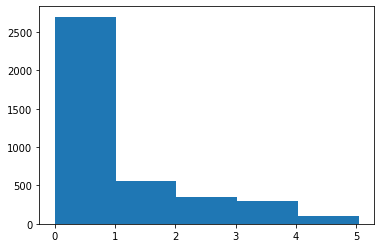

In [120]:
import matplotlib.pyplot as plt
plt.hist(eigen_values, bins = 5)
plt.show()

In [121]:
eigvals_bw01=[eigen_values[i] for i in range(len(eigen_values)) if eigen_values[i] <= 1]

In [122]:
eigvals_bw01

[-8.213024471025676e-16,
 -5.641476079871005e-16,
 -1.5406177234258375e-16,
 -6.208286804356891e-17,
 -6.035057042956965e-17,
 -1.062217067401929e-17,
 1.7056986151958173e-17,
 9.355875010677756e-17,
 1.0682721401356653e-16,
 1.4535595127347117e-16,
 2.0809599308143338e-16,
 0.014185135034093126,
 0.030223386520226724,
 0.08694616278696066,
 0.12242982315943271,
 0.12967526921777475,
 0.16857791247130977,
 0.19619649493833952,
 0.27265130364844303,
 0.29124962673917093,
 0.33771727142437913,
 0.36294409546638845,
 0.4612595230667781,
 0.643061438564107,
 0.7427996238683212,
 0.8266255834122074,
 0.8944774179485347,
 -7.0330225000654005e-16,
 -2.7646499242708613e-16,
 -1.791532650545675e-16,
 -1.555986906976517e-16,
 -1.4367767964358103e-16,
 -1.4355137758244534e-16,
 -1.4747055571798967e-17,
 9.200125392421519e-17,
 1.0973151366623809e-16,
 2.0517489845327983e-16,
 5.695730938426371e-16,
 0.01346168738486668,
 0.028982144590696122,
 0.08849635869637347,
 0.12263581868868222,
 0.1305594

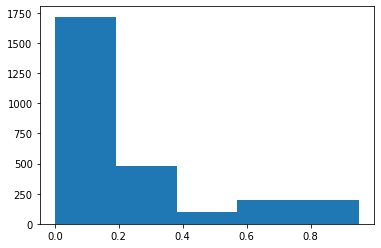

In [123]:
import matplotlib.pyplot as plt
plt.hist(eigvals_bw01, bins = 5)
plt.show()

In [124]:
eigen_values

[-8.213024471025676e-16,
 -5.641476079871005e-16,
 -1.5406177234258375e-16,
 -6.208286804356891e-17,
 -6.035057042956965e-17,
 -1.062217067401929e-17,
 1.7056986151958173e-17,
 9.355875010677756e-17,
 1.0682721401356653e-16,
 1.4535595127347117e-16,
 2.0809599308143338e-16,
 0.014185135034093126,
 0.030223386520226724,
 0.08694616278696066,
 0.12242982315943271,
 0.12967526921777475,
 0.16857791247130977,
 0.19619649493833952,
 0.27265130364844303,
 0.29124962673917093,
 0.33771727142437913,
 0.36294409546638845,
 0.4612595230667781,
 0.643061438564107,
 0.7427996238683212,
 0.8266255834122074,
 0.8944774179485347,
 1.0703161826691554,
 1.1183751222402274,
 1.4458029828650147,
 1.5671262841247482,
 1.7030330732764276,
 1.9542347039266499,
 2.3345807937368575,
 2.3865248583020184,
 2.822235964946898,
 3.3019091283710282,
 3.5502483806680285,
 3.857453881505134,
 4.897248600062843,
 -7.0330225000654005e-16,
 -2.7646499242708613e-16,
 -1.791532650545675e-16,
 -1.555986906976517e-16,
 -1.4